# DQN


### Training of DQN in Tensorflow
--------------------------

In [1]:
#
from util import *
from dlg_manager import *
from alg import *
from agent import *
from user_sim import *
from state_tracker import *
import random
from config import *
import matplotlib.pyplot as plt
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Load Data
-------------------

#### Action Set

In [2]:
#
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- confirm_answer: 3
- deny: 9
- confirm_question: 2
- not_sure: 10
- greeting: 4


### slot set

In [3]:
#
slots_set_path = "./data/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 29
Sample of dict:
- actor: 0
- theater_chain: 23
- numberofkids: 15
- movie_series: 11
- implicit_value: 10


### movie dic: info about movie

In [4]:
#
movie_kb_path = "./data/movie_kb.1k.p"
movie_kb = pickle.load(open(movie_kb_path, 'rb'), encoding="latin")
sample_dict(movie_kb, sample_size=1)

keys = 991
Sample of dict:
- 540: {'city': 'birmingham', 'moviename': 'london had fallen', 'theater': 'carmike summit 16', 'state': 'al', 'date': 'today', 'starttime': '1:35 pm'}


# Language Generator (pretrained)
-------------------

In [5]:
#
nlg_model_path = './data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./data/nlg/dia_act_nl_pairs.v6.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [6]:
#
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
params['batch_size'] = 16
batch_size = 16
save_check_point = 20
params['trained_model_path'] = None
for k in params:
    print("{}: {}".format(k, params[k]))

max_epochs: 200
slot_set: data/slot_set.txt
sdgtype: rmsprop
decay_rate: 0.999
eva_metric: 2
reg_cost: 0.001
dia_slot_val: 2
learning_rate: 0.001
pretrained_model_path: None
smooth_eps: 1e-08
data_path: .\data\movieMultiLine.Annot.Corrected.Final.v3.csv
feed_recurrence: 0
trained_model_path: None
hidden_size: 100
valid_test: 0
batch_size: 16
split_method: 1
cv_fold: 6
activation_func: relu
grad_clip: -0.0001
momentum: 0.1
model: lstm_tanh
save_check_point: 20
slot_rep: 1
init_rnn: 0
write_model_dir: .\checkpoints\template\07102016\
act_set: data/dia_acts.txt
check_point: 20


# User Simulator
-------------------

### goal

In [7]:
#
goal_file_path = './data/user_goals_first_turn_template.part.movie.v1.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'request_slots': {}, 'diaact': 'request', 'inform_slots': {'city': 'birmingham', 'moviename': 'zootopia', 'theater': 'carmike summit 16', 'state': 'al', 'date': 'today', 'numberofpeople': '1', 'starttime': 'around 2pm'}}


### Split goal set

In [8]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [9]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.00
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

### a movie dictionary for user simulator - slot:possible values

In [10]:
#
movie_dict_path = './data/user/dicts.v3.p'
movie_dictionary = pickle.load(open(movie_dict_path, 'rb'), encoding="latin")
samples = sample_dict(movie_dictionary, sample_size=1)

keys = 20
Sample of dict:
- starttime: ['10:30am', '11:10am', '1:10pm', '1:50pm', '3:45pm', '4:30pm', '5:20pm', '6:30pm', '7:15pm', '9:10pm', '10:30pm', '12:30pm', '9:30pm', '9:30', '8:40pm', '7:00pm', '9:50pm', 'none', 'before 4pm', '12:00', '1:10', '2:40', '3:50', 'around 2pm', '1:30', '4:00', 'night', '11:05am', '1:45pm', '7:20 pm', '4:35pm', '10pm', '10 pm', 'latest showing', '9:00 pm', 'around 6pm', '7:20', '9:10 pm', '8:45 pm', '8:45', '9:50 pm', 'around 3 pm', '12pm', '9:30 pm', '6pm', '9:01pm', '5:30pm', '8:00pm', '10:40pm', '2:30pm', '5:10pm', '10:00pm', '7:15 pm', '7pm', 'around 7pm', 'earliest showing', '12:45pm', '1:15pm', '12:45', '12:35pm', ' 4:05pm', ' 7:05pm', ' 9:55pm', '7:05 pm', 'after dinner', 'after 7:30pm', '10:50pm', '7:50pm', '10:20pm', '8pm', '8:20', '8:15pm', 'between 9 and 10', '10:20', 'after 7pm', '4:40 pm', 'before dinner', '7:10 pm', 'betwenn 8-10 pm', '4 pm', '4:20', '4:20pm', 'from noon to 4pm', '8:30pm', '11:00pm', '11pm', ' Matinee', '4pm to 7pm', '6:

###  Create a User

In [11]:
user = RuleSimulator(movie_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# Agent
-------------------

## param

In [12]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 40
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = True
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

success_rate_threshold = 0.3

pretrained model path = None


### create an agent

In [13]:
# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
# agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
# agt = 9
agt = 10
agent_params['batch_size']  = batch_size
if agt == 9:
    agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
else:
    agent = DQNAgentTF(movie_kb, act_set, slot_set, agent_params)

agent.set_nlg_model(nlg_model)

act_cardinality  11
feasible_actions 43
80


# Dialog Manager
-------------------

In [14]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, movie_kb)

## Running Episodes
-------------------

### Param

In [15]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 100
# the number of epochs for warm start 
warm_start_epochs = 50
# num_episodes = 60

In [16]:
""" Warm_Start Simulation (by Rule Policy) """
def warm_start_simulation():
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(warm_start_epochs):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("warm_start simulation episode %s: Success" % (episode))
#                 else: print ("warm_start simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        if len(agent.experience_replay_pool) >= agent.experience_replay_pool_size:
            break
    
    agent.warm_start = 2
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print ("Warm_Start %s epochs, success rate %s, ave reward %s, ave turns %s" % (episode+1, res['success_rate'], res['ave_reward'], res['ave_turns']))
    print ("Current experience replay buffer size %s" % (len(agent.experience_replay_pool)))

In [17]:
def simulation_epoch(simulation_epoch_size):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(simulation_epoch_size):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("simulation episode %s: Success" % (episode))
#                 else: print ("simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
    
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print("simulation success rate %s, ave reward %s, ave turns %s" % (res['success_rate'], res['ave_reward'], res['ave_turns']))
    return res

In [18]:
def run_episodes(count, status):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    
    if agt >= 9 and params['trained_model_path'] == None and agent.warm_start == 1:
        print ('warm_start starting ...')
        warm_start_simulation()
        print ('warm_start finished, start RL training ...')
    
    for episode in range(count):
        print ("----------------- Episode: %s ----------------- " % (episode))
        dlg_manager.init_episode()
        episode_over = False
        
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
                
            if episode_over:
                if reward > 0:
                    print ("Successful Dialog!")
                    successes += 1
#                 else: print ("Failed Dialog!")
                
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        # simulation
        if agt >= 9 and params['trained_model_path'] == None:
            agent.predict_mode = True
            simulation_res = simulation_epoch(simulation_epoch_size)
            
            performance_records['success_rate'][episode] = simulation_res['success_rate']
            performance_records['ave_turns'][episode] = simulation_res['ave_turns']
            performance_records['ave_reward'][episode] = simulation_res['ave_reward']
            
            if simulation_res['success_rate'] >= best_res['success_rate']:
                if simulation_res['success_rate'] >= success_rate_threshold: # threshold = 0.30
                    agent.experience_replay_pool = [] 
                    simulation_epoch(simulation_epoch_size)
                
#             if simulation_res['success_rate'] > best_res['success_rate']:
#                 best_model['model'] = copy.deepcopy(agent)
#                 best_res['success_rate'] = simulation_res['success_rate']
#                 best_res['ave_reward'] = simulation_res['ave_reward']
#                 best_res['ave_turns'] = simulation_res['ave_turns']
#                 best_res['epoch'] = episode
                
            loss = agent.train(batch_size, 1)
            if agt == 10: 
                agent.model.update_target_params()
            else: 
                agent.clone_dqn = copy.deepcopy(agent.dqn)
                
            agent.predict_mode = False
            
            print ("Simulation success rate %s, Ave reward %s, Ave turns %s, Best success rate %s" % (performance_records['success_rate'][episode], performance_records['ave_reward'][episode], performance_records['ave_turns'][episode], best_res['success_rate']))
#             if episode % save_check_point == 0 and params['trained_model_path'] == None: # save the model every 10 episodes
#                 save_model(params['write_model_dir'], agt, best_res['success_rate'], best_model['model'], best_res['epoch'], episode)
#                 save_performance_records(params['write_model_dir'], agt, performance_records)
        curve.append(successes/(episode+1))
        losses.append(loss)
        print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (episode+1, count, successes, episode+1, float(cumulative_reward)/(episode+1), float(cumulative_turns)/(episode+1)))
    print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (successes, count, float(cumulative_reward)/count, float(cumulative_turns)/count))
    status['successes'] += successes
    status['count'] += count
    
#     if agt == 9 and params['traained_model_path'] == None:
#         save_model(params['write_model_dir'], agt, float(successes)/count, best_model['model'], best_res['epoch'], count)
#         save_performance_records(params['write_model_dir'], agt, performance_records)


## Run a Warm Start

# Train & Eval
-------------------

In [19]:
performance_records = {}
performance_records['success_rate'] = {}
performance_records['ave_turns'] = {}
performance_records['ave_reward'] = {}

best_model = {}
best_res = {'success_rate': 0, 'ave_reward':float('-inf'), 'ave_turns': float('inf'), 'epoch':0}

curve = []
losses = []
agent.warm_start = 1
run_episodes(200, status)

warm_start starting ...
Warm_Start 50 epochs, success rate 0.19, ave reward -0.7, ave turns 8.0
Current experience replay buffer size 400
warm_start finished, start RL training ...
----------------- Episode: 0 ----------------- 
simulation success rate 0.0, ave reward -59.92, ave turns 41.84
Train on : 2513
- cur bellman err 7.1333, experience replay pool 2513
Simulation success rate 0.0, Ave reward -59.92, Ave turns 41.84, Best success rate 0
Progress: 1 / 200, Success rate: 0 / 1 Avg reward: -60.00 Avg turns: 42.00
----------------- Episode: 1 ----------------- 
simulation success rate 0.0, ave reward -41.2, ave turns 4.4
Train on : 2733
- cur bellman err 10.1354, experience replay pool 2733
Simulation success rate 0.0, Ave reward -41.2, Ave turns 4.4, Best success rate 0
Progress: 2 / 200, Success rate: 0 / 2 Avg reward: -50.00 Avg turns: 22.00
----------------- Episode: 2 ----------------- 
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 4833
- cur bellman 

simulation success rate 0.52, ave reward 10.24, ave turns 26.32
simulation success rate 0.51, ave reward 9.75, ave turns 24.9
Train on : 1245
- cur bellman err 6.0363, experience replay pool 1245
Simulation success rate 0.52, Ave reward 10.24, Ave turns 26.32, Best success rate 0
Progress: 24 / 200, Success rate: 1 / 24 Avg reward: -52.54 Avg turns: 37.08
----------------- Episode: 24 ----------------- 
simulation success rate 0.53, ave reward 10.54, ave turns 28.12
simulation success rate 0.49, ave reward 5.69, ave turns 28.22
Train on : 1411
- cur bellman err 3.0454, experience replay pool 1411
Simulation success rate 0.53, Ave reward 10.54, Ave turns 28.12, Best success rate 0
Progress: 25 / 200, Success rate: 1 / 25 Avg reward: -52.84 Avg turns: 37.28
----------------- Episode: 25 ----------------- 
Successful Dialog!
simulation success rate 0.53, ave reward 10.33, ave turns 28.54
simulation success rate 0.59, ave reward 18.65, ave turns 26.3
Train on : 1315
- cur bellman err 2.331

simulation success rate 0.53, ave reward 12.64, ave turns 23.92
simulation success rate 0.55, ave reward 15.09, ave turns 23.82
Train on : 1191
- cur bellman err 7.1799, experience replay pool 1191
Simulation success rate 0.53, Ave reward 12.64, Ave turns 23.92, Best success rate 0
Progress: 44 / 200, Success rate: 10 / 44 Avg reward: -28.59 Avg turns: 33.73
----------------- Episode: 44 ----------------- 
Successful Dialog!
simulation success rate 0.63, ave reward 23.89, ave turns 25.42
simulation success rate 0.64, ave reward 25.22, ave turns 25.16
Train on : 1258
- cur bellman err 6.3423, experience replay pool 1258
Simulation success rate 0.63, Ave reward 23.89, Ave turns 25.42, Best success rate 0
Progress: 45 / 200, Success rate: 11 / 45 Avg reward: -26.51 Avg turns: 33.69
----------------- Episode: 45 ----------------- 
simulation success rate 0.73, ave reward 39.35, ave turns 18.5
simulation success rate 0.68, ave reward 32.64, ave turns 19.92
Train on : 996
- cur bellman err 1

simulation success rate 0.75, ave reward 40.75, ave turns 20.5
simulation success rate 0.73, ave reward 38.96, ave turns 19.28
Train on : 964
- cur bellman err 6.8358, experience replay pool 964
Simulation success rate 0.75, Ave reward 40.75, Ave turns 20.5, Best success rate 0
Progress: 64 / 200, Success rate: 21 / 64 Avg reward: -14.72 Avg turns: 30.19
----------------- Episode: 64 ----------------- 
simulation success rate 0.69, ave reward 35.02, ave turns 17.56
simulation success rate 0.7, ave reward 36.18, ave turns 17.64
Train on : 882
- cur bellman err 9.1371, experience replay pool 882
Simulation success rate 0.69, Ave reward 35.02, Ave turns 17.56, Best success rate 0
Progress: 65 / 200, Success rate: 21 / 65 Avg reward: -15.34 Avg turns: 30.22
----------------- Episode: 65 ----------------- 
simulation success rate 0.72, ave reward 37.0, ave turns 20.8
simulation success rate 0.64, ave reward 26.41, ave turns 22.78
Train on : 1139
- cur bellman err 6.8088, experience replay p

simulation success rate 0.77, ave reward 43.74, ave turns 19.32
simulation success rate 0.82, ave reward 50.84, ave turns 17.12
Train on : 856
- cur bellman err 6.0655, experience replay pool 856
Simulation success rate 0.77, Ave reward 43.74, Ave turns 19.32, Best success rate 0
Progress: 84 / 200, Success rate: 31 / 84 Avg reward: -8.99 Avg turns: 28.55
----------------- Episode: 84 ----------------- 
Successful Dialog!
simulation success rate 0.81, ave reward 49.38, ave turns 17.64
simulation success rate 0.74, ave reward 40.39, ave turns 18.82
Train on : 941
- cur bellman err 5.4676, experience replay pool 941
Simulation success rate 0.81, Ave reward 49.38, Ave turns 17.64, Best success rate 0
Progress: 85 / 200, Success rate: 32 / 85 Avg reward: -8.08 Avg turns: 28.52
----------------- Episode: 85 ----------------- 
Successful Dialog!
simulation success rate 0.82, ave reward 50.97, ave turns 16.86
simulation success rate 0.79, ave reward 46.62, ave turns 18.36
Train on : 918
- cur

simulation success rate 0.79, ave reward 46.86, ave turns 17.88
simulation success rate 0.8, ave reward 48.52, ave turns 16.96
Train on : 848
- cur bellman err 4.9937, experience replay pool 848
Simulation success rate 0.79, Ave reward 46.86, Ave turns 17.88, Best success rate 0
Progress: 104 / 200, Success rate: 48 / 104 Avg reward: 3.40 Avg turns: 25.96
----------------- Episode: 104 ----------------- 
Successful Dialog!
simulation success rate 0.81, ave reward 49.44, ave turns 17.52
simulation success rate 0.72, ave reward 37.94, ave turns 18.92
Train on : 946
- cur bellman err 5.1631, experience replay pool 946
Simulation success rate 0.81, Ave reward 49.44, Ave turns 17.52, Best success rate 0
Progress: 105 / 200, Success rate: 49 / 105 Avg reward: 4.09 Avg turns: 25.83
----------------- Episode: 105 ----------------- 
Successful Dialog!
simulation success rate 0.84, ave reward 54.06, ave turns 15.48
simulation success rate 0.84, ave reward 53.56, ave turns 16.48
Train on : 824
- 

simulation success rate 0.74, ave reward 41.82, ave turns 15.96
simulation success rate 0.77, ave reward 45.0, ave turns 16.8
Train on : 840
- cur bellman err 7.3271, experience replay pool 840
Simulation success rate 0.74, Ave reward 41.82, Ave turns 15.96, Best success rate 0
Progress: 124 / 200, Success rate: 62 / 124 Avg reward: 8.69 Avg turns: 24.61
----------------- Episode: 124 ----------------- 
Successful Dialog!
simulation success rate 0.85, ave reward 54.93, ave turns 16.14
simulation success rate 0.76, ave reward 43.32, ave turns 17.76
Train on : 888
- cur bellman err 5.4918, experience replay pool 888
Simulation success rate 0.85, Ave reward 54.93, Ave turns 16.14, Best success rate 0
Progress: 125 / 200, Success rate: 63 / 125 Avg reward: 9.22 Avg turns: 24.53
----------------- Episode: 125 ----------------- 
Successful Dialog!
simulation success rate 0.85, ave reward 55.01, ave turns 15.98
simulation success rate 0.82, ave reward 51.37, ave turns 16.06
Train on : 803
- c

simulation success rate 0.78, ave reward 46.33, ave turns 16.54
simulation success rate 0.82, ave reward 51.16, ave turns 16.48
Train on : 824
- cur bellman err 5.3562, experience replay pool 824
Simulation success rate 0.78, Ave reward 46.33, Ave turns 16.54, Best success rate 0
Progress: 144 / 200, Success rate: 79 / 144 Avg reward: 15.20 Avg turns: 23.26
----------------- Episode: 144 ----------------- 
simulation success rate 0.77, ave reward 45.71, ave turns 15.38
simulation success rate 0.79, ave reward 46.97, ave turns 17.66
Train on : 883
- cur bellman err 5.0094, experience replay pool 883
Simulation success rate 0.77, Ave reward 45.71, Ave turns 15.38, Best success rate 0
Progress: 145 / 200, Success rate: 79 / 145 Avg reward: 14.68 Avg turns: 23.39
----------------- Episode: 145 ----------------- 
Successful Dialog!
simulation success rate 0.61, ave reward 24.73, ave turns 18.94
simulation success rate 0.62, ave reward 25.87, ave turns 19.06
Train on : 953
- cur bellman err 

simulation success rate 0.76, ave reward 42.9, ave turns 18.6
simulation success rate 0.76, ave reward 43.54, ave turns 17.32
Train on : 866
- cur bellman err 7.8279, experience replay pool 866
Simulation success rate 0.76, Ave reward 42.9, Ave turns 18.6, Best success rate 0
Progress: 164 / 200, Success rate: 91 / 164 Avg reward: 16.01 Avg turns: 23.16
----------------- Episode: 164 ----------------- 
Successful Dialog!
simulation success rate 0.75, ave reward 41.9, ave turns 18.2
simulation success rate 0.75, ave reward 42.07, ave turns 17.86
Train on : 893
- cur bellman err 5.2980, experience replay pool 893
Simulation success rate 0.75, Ave reward 41.9, Ave turns 18.2, Best success rate 0
Progress: 165 / 200, Success rate: 92 / 165 Avg reward: 16.36 Avg turns: 23.09
----------------- Episode: 165 ----------------- 
Successful Dialog!
simulation success rate 0.81, ave reward 50.06, ave turns 16.28
simulation success rate 0.77, ave reward 44.97, ave turns 16.86
Train on : 843
- cur b

simulation success rate 0.73, ave reward 39.51, ave turns 18.18
simulation success rate 0.81, ave reward 50.0, ave turns 16.4
Train on : 820
- cur bellman err 7.9320, experience replay pool 820
Simulation success rate 0.73, Ave reward 39.51, Ave turns 18.18, Best success rate 0
Progress: 184 / 200, Success rate: 108 / 184 Avg reward: 20.25 Avg turns: 22.37
----------------- Episode: 184 ----------------- 
simulation success rate 0.77, ave reward 45.01, ave turns 16.78
simulation success rate 0.79, ave reward 47.61, ave turns 16.38
Train on : 819
- cur bellman err 8.7729, experience replay pool 819
Simulation success rate 0.77, Ave reward 45.01, Ave turns 16.78, Best success rate 0
Progress: 185 / 200, Success rate: 108 / 185 Avg reward: 19.82 Avg turns: 22.48
----------------- Episode: 185 ----------------- 
Successful Dialog!
simulation success rate 0.76, ave reward 43.3, ave turns 17.8
simulation success rate 0.75, ave reward 42.56, ave turns 16.88
Train on : 844
- cur bellman err 8.

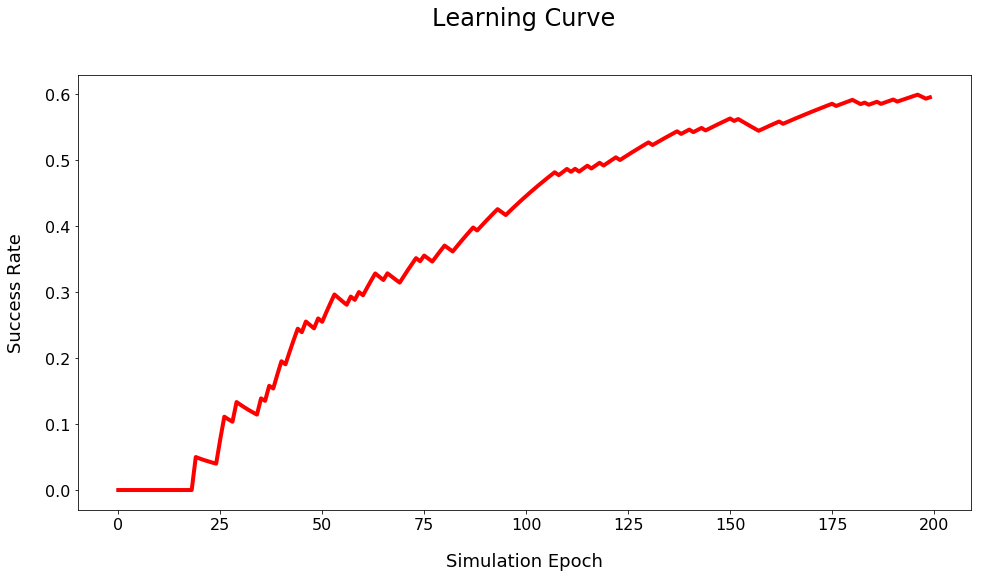

In [20]:
draw_learning_curve(curve)

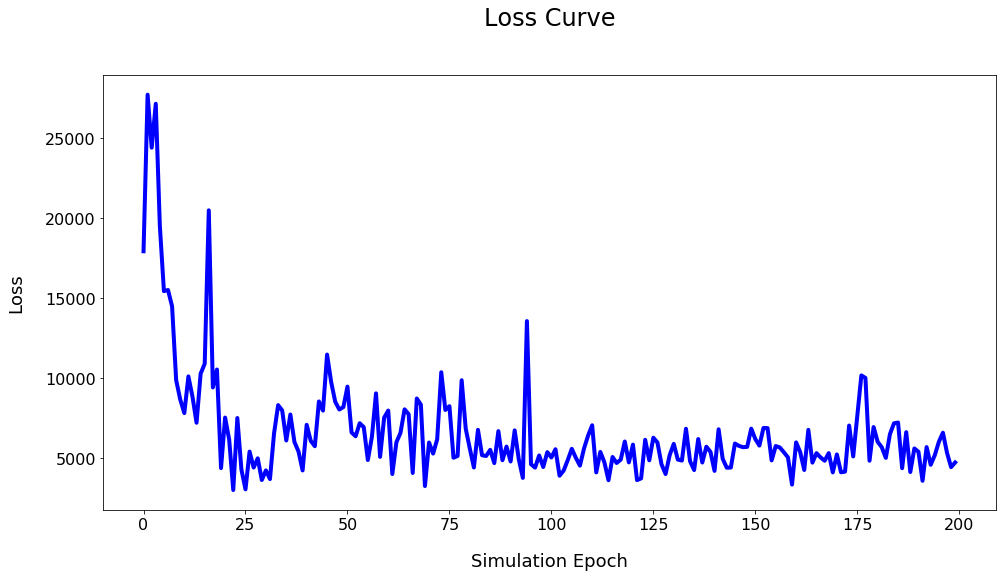

In [21]:
draw_loss_curve(losses)

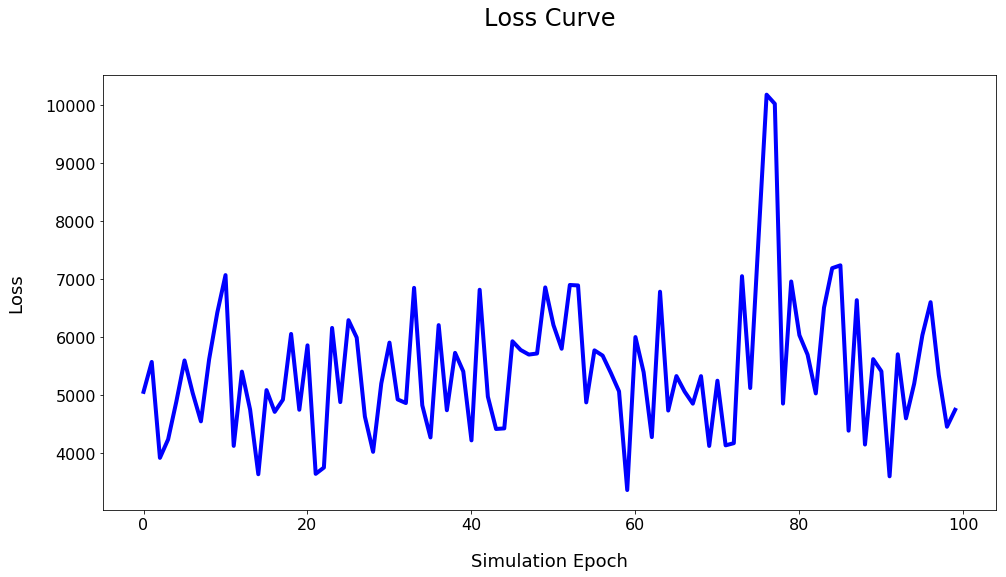

In [22]:
draw_loss_curve(losses[-100:])

In [23]:
saver = tf.train.Saver()

In [24]:
# saver.save(agent.model.sess, "trained_model/tf_400/", global_step = 400)  

In [25]:
curve

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.047619047619047616,
 0.045454545454545456,
 0.043478260869565216,
 0.041666666666666664,
 0.04,
 0.07692307692307693,
 0.1111111111111111,
 0.10714285714285714,
 0.10344827586206896,
 0.13333333333333333,
 0.12903225806451613,
 0.125,
 0.12121212121212122,
 0.11764705882352941,
 0.11428571428571428,
 0.1388888888888889,
 0.13513513513513514,
 0.15789473684210525,
 0.15384615384615385,
 0.175,
 0.1951219512195122,
 0.19047619047619047,
 0.20930232558139536,
 0.22727272727272727,
 0.24444444444444444,
 0.2391304347826087,
 0.2553191489361702,
 0.25,
 0.24489795918367346,
 0.26,
 0.2549019607843137,
 0.2692307692307692,
 0.2830188679245283,
 0.2962962962962963,
 0.2909090909090909,
 0.2857142857142857,
 0.2807017543859649,
 0.29310344827586204,
 0.288135593220339,
 0.3,
 0.29508196721311475,
 0.3064516129032258,
 0.31746031746031744,
 0.328125,
 0.3230769230769231,
 